<a href="https://colab.research.google.com/github/gagansingh23/AirBnB-NYC/blob/master/NYC_AIRBNB_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook will be used to help develop machine learning algorithms to predict AirBnB prices in New York City. Using the dataset from 'https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data', we will use different techniques to first clean and prepare the data. Then we will explore the dataset to see if we can find anything interesting through visualizations and help set up our final model. The goal of the final model is to have better scoring metrics than our first model. As we go through the notebook we will find somethings are more important than others to predict prices, which will help finalize our last model on test set.  

#Uploading The Dataset, and importing necessary Installers 

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

In [100]:
#The link is uploaded through my github repository
!wget 'https://github.com/gagansingh23/Unit-2-Project/blob/master/AB_NYC_2019.csv.zip?raw=true'

--2020-02-07 06:37:46--  https://github.com/gagansingh23/Unit-2-Project/blob/master/AB_NYC_2019.csv.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/gagansingh23/AirBnB-NYC/blob/master/AB_NYC_2019.csv.zip?raw=true [following]
--2020-02-07 06:37:47--  https://github.com/gagansingh23/AirBnB-NYC/blob/master/AB_NYC_2019.csv.zip?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/gagansingh23/AirBnB-NYC/raw/master/AB_NYC_2019.csv.zip [following]
--2020-02-07 06:37:47--  https://github.com/gagansingh23/AirBnB-NYC/raw/master/AB_NYC_2019.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gagansingh23/AirBnB-NYC/master/AB_NYC_2019.csv.zip [follo

**Import Installers**

In [0]:
import pandas as pd
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance
pd.options.display.float_format = '{:,.0f}'.format

In [102]:
#Read in the dataframe, also if downloaded as zip use !unzip
df = pd.read_csv('AB_NYC_2019.csv.zip')
!unzip AB_NYC_2019.csv.zip

Archive:  AB_NYC_2019.csv.zip
replace AB_NYC_2019.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
df = pd.read_csv('AB_NYC_2019.csv')

Lets Take a Look at the top 5 rows of the dataset, and we can then start our cleaning. 

In [104]:
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,41,-74,Private room,149,1,9,2018-10-19,0,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,41,-74,Entire home/apt,225,1,45,2019-05-21,0,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,41,-74,Private room,150,3,0,NaN,nan,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,41,-74,Entire home/apt,89,1,270,2019-07-05,5,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,41,-74,Entire home/apt,80,10,9,2018-11-19,0,1,0


#Cleaning Original Dataframe#

There are some spelling errors for column names in this dataset, we will use .rename and a dictionary key to fix the column headers

In [0]:
df = df.rename(columns={'neighbourhood': 'neighborhood', 'neighbourhood_group' :'neighborhood_group'})

In [106]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighborhood_group',
       'neighborhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

Our target of this predictive analysis is the 'price' column in the dataset, lets examine how price is distributed. 

In [107]:
df.price.describe()

count   48,895
mean       153
std        240
min          0
25%         69
50%        106
75%        175
max     10,000
Name: price, dtype: float64

There seems to be some free airbnb's in the dataset, as well as some extreme high prices especially since Airbnb uses a set nightly basis price, lets examine this further.

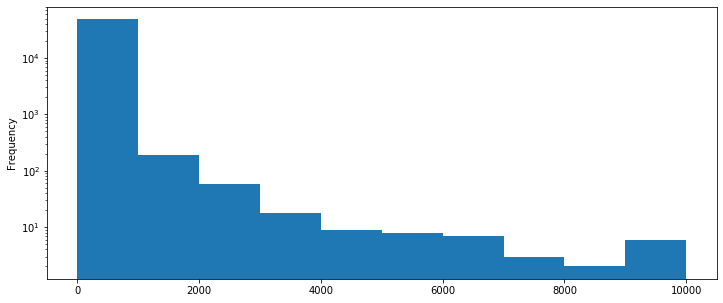

In [108]:
df.price.plot(kind='hist', log=True, figsize=(12,5))

In [109]:
#Find Outliers 
df[(df['price'] <= np.percentile(df['price'], 0.5))]

,id,name,host_id,host_name,neighborhood_group,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
957,375249,Enjoy Staten Island Hospitality,1887999,Rimma & Jim,Staten Island,Graniteville,41,-74,Private room,20,3,80,2019-05-26,1,1,226
2860,1620248,Large furnished 2 bedrooms- - 30 days Minimum,2196224,Sally,Manhattan,East Village,41,-74,Entire home/apt,10,30,0,NaN,nan,4,137
3918,2431607,"Bright, Airy Room Share for 2",4973668,Gloria,Brooklyn,Bedford-Stuyvesant,41,-74,Shared room,25,5,76,2019-06-06,1,3,258
3950,2459916,"$455 Cozy 1bd, BKLYN Sublet March",12577771,Victor,Brooklyn,Bedford-Stuyvesant,41,-74,Private room,18,1,0,NaN,nan,1,0
4647,3258197,Large 1br Duplex in Heart of Upper East Side,16477306,Jeff,Manhattan,Upper East Side,41,-74,Entire home/apt,16,2,21,2019-06-30,2,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48312,36199363,Furnished room for rent in Bronx SINGLE FEMALE,272247972,Kadeen,Bronx,Olinville,41,-74,Shared room,25,90,0,NaN,nan,1,190
48486,36280646,"Cable and wfi, L/G included.",272872092,Chris,Queens,Forest Hills,41,-74,Entire home/apt,16,9,1,2019-07-07,1,1,322
48832,36450814,FLATBUSH HANG OUT AND GO,267223765,Jarmel,Brooklyn,Flatbush,41,-74,Shared room,20,1,0,NaN,nan,3,363
48867,36473044,The place you were dreaming for.(only for guys),261338177,Diana,Brooklyn,Gravesend,41,-74,Shared room,25,1,0,NaN,nan,6,338


In [110]:
df[(df['price'] >= np.percentile(df['price'], 99.8))] 

,id,name,host_id,host_name,neighborhood_group,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
496,174966,Luxury 2Bed/2.5Bath Central Park View,836168,Henry,Manhattan,Upper West Side,41,-74,Entire home/apt,2000,30,30,2018-05-05,0,11,0
946,363673,Beautiful 3 bedroom in Manhattan,256239,Tracey,Manhattan,Upper West Side,41,-74,Private room,3000,7,0,NaN,nan,1,365
1480,664047,Lux 2Bed/2.5Bath Central Park Views,836168,Henry,Manhattan,Upper West Side,41,-74,Entire home/apt,2000,30,59,2016-01-28,1,11,364
1862,826690,"Sunny, Family-Friendly 2 Bedroom",4289240,Lucy,Brooklyn,Prospect Heights,41,-74,Entire home/apt,4000,4,0,NaN,nan,1,83
2018,893413,Architecturally Stunning Former Synagogue!,4751930,Martin,Manhattan,East Village,41,-74,Entire home/apt,2500,30,15,2019-07-01,0,1,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46533,35297214,Amazing Chelsea 4BR Loft!,256649546,Viberlyn,Manhattan,Chelsea,41,-74,Entire home/apt,2995,30,1,2019-06-24,1,1,214
46614,35345358,Northside Williamsburg Stunner,956324,Alex,Brooklyn,Williamsburg,41,-74,Entire home/apt,4500,30,0,NaN,nan,1,365
47350,35706068,wait until later,35741633,Chen,Queens,Long Island City,41,-74,Entire home/apt,2000,1,0,NaN,nan,1,365
48043,36056808,Luxury TriBeCa Apartment at an amazing price,271248669,Jenny,Manhattan,Tribeca,41,-74,Entire home/apt,6500,180,0,NaN,nan,1,365


We will remove outliers for price, because they will have a negative impact on our predictions. Outliers will impact other points that fit accordingly to the data. 

In [0]:
def remove_outliers(X):
  
  X = X[(X['price'] >= np.percentile(X['price'], 0.5)) & 
        (X['price'] <= np.percentile(X['price'], 99.5))] 

  return X
df = remove_outliers(df)

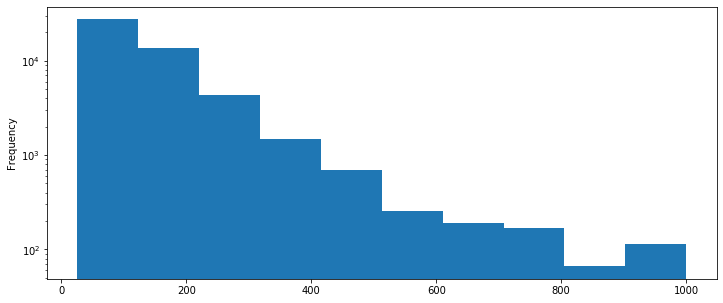

In [112]:
df.price.plot(kind='hist', log=True, figsize=(12,5))

#Mean Baseline/ First Model#

Split the data into X and Y, use randominzed split into train sets, validation sets, and our final test set. 

In [0]:
X = df.drop(columns='price', axis=1)
y = df['price']


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, test_size=0.20,
                              random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.95, test_size=.05,
                               random_state=42)


We will begin with a quick model so we can then set a foundation and work from there. The information that we can use for now is the mean average price for each AirBnB, this is a good way to start to  set the standard that if we were to predict each price using the average, how far will we be off. Throughout the notebook we will try to beat this first score. 

In [114]:
#Begin with a first mean baseline

guess = y_train.mean()
errors = guess - df['price']

y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Mean Absolute Error:", mae)
print("R2 score:", r2)
print(f"We would be off by $",mae)

Mean Absolute Error: 77.60250232533674
R2 score: 0.0
We would be off by $ 77.60250232533674


For our first model, we will use Linear Regression, its the simplest model in my opinion to examine the price. We will use number of reviews as a feature, people tend to stay at more places if they are more reviews. Were also going to be using mean absolute error and r2 score, Mean Absolute Error expresses the average error between prediction and actual variable. R2 Score is a good statistical measurement for how well the regression model predicts to the actual data points.  

In [115]:
lin = LinearRegression()
features = ['number_of_reviews']
X = X_train[features]
Y = y_train

print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['number_of_reviews']


In [116]:
lin.fit(X, Y)
y_pred = lin.predict(X)
mae = mean_absolute_error(Y, y_pred)

print(f'Mean_Absolute_error: {mae:.2f} dollars')
print("R2 score:", r2)

Mean_Absolute_error: 77.44 dollars
R2 score: 0.0


We Start off with a Mean Absolute Error of 73.15, and r2 score of 0, so we would be off by an average of 73$, its a good start because it can only go up from here.

##Data Exploration##

AirBnB's are split between three different room types. Entire houses would usually cost more than private or shared rooms, we can examine how well this data can correlate to our predictions. 

In [117]:
X_train.room_type.value_counts()

Entire home/apt    19133
Private room       16886
Shared room          784
Name: room_type, dtype: int64

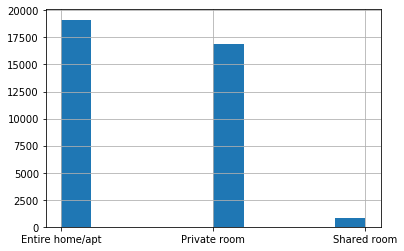

In [118]:
X_train['room_type'].hist(bins=10);

New York City is split into 5 boroughs, Manhattan has no homes in it except for business and apartment condo buildings, the other boroughs have a mix of homes and apartments. Staten Island is somewhat secluded from the other boroughs as it is harder to access than the others. This could be important to figure out how location can play some feature importance to price. 

In [119]:
df.groupby('neighborhood_group')['price'].mean()

neighborhood_group
Bronx            87
Brooklyn        118
Manhattan       179
Queens           96
Staten Island   100
Name: price, dtype: float64

![alt text](https://www.nyctourist.com/images/maps/nyc-boroughs-map.jpg)

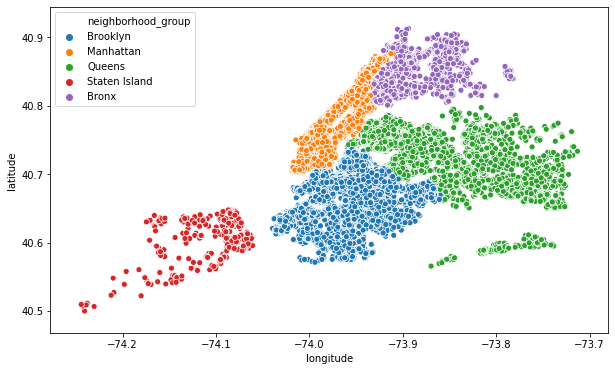

In [120]:
#Examine The graph to see if there any outliers or extremes. 
plt.figure(figsize=(10,6))
sns.scatterplot(df['longitude'],df['latitude'],hue=df.neighborhood_group )
plt.show()




*Check for Null Values*

In [121]:
X_train.isnull().sum()

id                                   0
name                                11
host_id                              0
host_name                           15
neighborhood_group                   0
neighborhood                         0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
last_review                       7489
reviews_per_month                 7489
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [0]:
def fill_null_values(df):
  df = df.copy()

  df['last_review'] = df['last_review'].fillna(0)
  df['reviews_per_month'] = df['reviews_per_month'].fillna(df["reviews_per_month"].mean())

  return df

In [0]:
#Apply function to our vectors
X_train = fill_null_values(X_train)
X_val = fill_null_values(X_val)
X_test = fill_null_values(X_test)

In [124]:
#Check for Null Values
X_train.isnull().sum()

id                                 0
name                              11
host_id                            0
host_name                         15
neighborhood_group                 0
neighborhood                       0
latitude                           0
longitude                          0
room_type                          0
minimum_nights                     0
number_of_reviews                  0
last_review                        0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

Okay we've cleared the nulls for now, lets engineer some new features. Availability and minimum nights could be a good ratio to help present more feature importance. 

In [0]:
#How many days available compared to how many nights required
def engineer_feature(X_train):
  
  X_train = X_train.copy()
  
  X_train['availability_by_minimum_nights'] = X_train['availability_365'] / X_train['minimum_nights']

  division = X_train['availability_365'] / 12.0
 
  X_train['reviews_per_day_available'] = X_train['reviews_per_month'] / (division)
                                                                         
  return (X_train)



In [0]:
X_train = engineer_feature(X_train)
X_val = engineer_feature(X_val)
X_test = engineer_feature(X_test)

In [0]:
#reviews per month / availability / 12 

division = X_train['availability_365'] / 12.0
 
X_train['reviews_per_day_available'] = X_train['reviews_per_month'] / (division)

X_train['reviews_per_day_available'] = X_train['reviews_per_day_available'].replace(-np.inf, np.nan)

There were some infintie numbers created because of some 0 values, creating soome floats, we will just reapply the function and a new instance to deal with the infinite numbers. 

In [0]:
def fill_null_values(df):
  df = df.copy()

  df['last_review'] = df['last_review'].fillna(0)
  df['reviews_per_month'] = df['reviews_per_month'].fillna(df["reviews_per_month"].mean())
  df['reviews_per_day_available'] = df['reviews_per_day_available'].fillna(df['reviews_per_day_available'].fillna(0))
  return df

In [0]:
X_train = fill_null_values(X_train)
X_val = fill_null_values(X_val)
X_test = fill_null_values(X_test)

#Explore Features with another model



I usually like to build another model to really test the feature importance. I would like to see how the tree model will fit using all columns in the data frame except id, name, host_id, host_name, I believe these are columns that wont pay a role in predicting price, and could just add more disruption to the predictive model. Airbnb's do have a filter for superhost on their website however, this dataframe wont have enough data for this instance. 

In [130]:
X_train.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighborhood_group',
       'neighborhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'availability_by_minimum_nights', 'reviews_per_day_available'],
      dtype='object')

In [0]:
features = ['number_of_reviews', 'neighborhood_group', 'neighborhood', 'latitude',
            'longitude', 'room_type', 'minimum_nights', 'reviews_per_month', 
            'calculated_host_listings_count', 'availability_365', 'availability_by_minimum_nights']

X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]     

In [132]:
#Columns were succesfully removed for this model validation
X_train

,number_of_reviews,neighborhood_group,neighborhood,latitude,longitude,room_type,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,availability_by_minimum_nights
45519,4,Brooklyn,Greenpoint,41,-74,Entire home/apt,3,3,1,181,60
25847,4,Brooklyn,Williamsburg,41,-74,Entire home/apt,5,0,1,0,0
30499,7,Brooklyn,Williamsburg,41,-74,Entire home/apt,6,0,1,0,0
22741,4,Manhattan,Harlem,41,-74,Private room,30,0,8,291,10
43798,1,Brooklyn,Bedford-Stuyvesant,41,-74,Private room,4,1,1,17,4
...,...,...,...,...,...,...,...,...,...,...,...
21493,43,Manhattan,Midtown,41,-74,Entire home/apt,2,1,1,0,0
9211,177,Manhattan,Flatiron District,41,-74,Entire home/apt,1,4,1,268,268
47773,0,Brooklyn,Crown Heights,41,-74,Private room,3,1,1,22,7
20393,93,Brooklyn,Bedford-Stuyvesant,41,-74,Private room,1,3,2,2,2


There are some categorical variables which should be encoded so the program can use numeric values for regression. We will encode to our variables or you can include into pipeline. 

In [0]:
#Encode each variable
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

**2nd model to fit and test on validation set**, it may take a few seconds for it to load and fit. 

In [134]:
pipeline = make_pipeline(
    XGBRegressor(n_estimators=150, random_state=42, n_jobs=-1, max_depth=5, min_child_weight=2)
)

pipeline.fit(X_train_encoded, y_train)

[06:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=5, min_child_weight=2,
                              missing=None, n_estimators=150, n_jobs=-1,
                              nthread=None, objective='reg:linear',
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1))],
         verbose=False)

In [135]:
y_pred = pipeline.predict(X_val_encoded)
print('Mean Absolute Error', mean_absolute_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(r2)

Mean Absolute Error 49.24749980166311
0.44147149665897456


This score was definitely better, and a much improved model on our validation set. There are some features that effect the price, lets use Eli5 a permutations importance in python to help find the weights of the features. 

#Eli5#

In [136]:
# 1. Calculate permutation importances
permuter = PermutationImportance(
    pipeline, 
    scoring='neg_mean_absolute_error', 
)

permuter.fit(X_val_encoded, y_val)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('xgbregressor',
                                                 XGBRegressor(base_score=0.5,
                                                              booster='gbtree',
                                                              colsample_bylevel=1,
                                                              colsample_bynode=1,
                                                              colsample_bytree=1,
                                                              gamma=0,
                                                              importance_type='gain',
                                                              learning_rate=0.1,
                                                              max_delta_step=0,
                                                              max_depth=5,
                                                

In [138]:
feature_names = X_val_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

neighborhood_Harlem              -0
neighborhood_group_Brooklyn      -0
neighborhood_Boerum Hill         -0
neighborhood_Red Hook            -0
neighborhood_Tribeca             -0
                                 ..
minimum_nights                    4
latitude                          5
availability_by_minimum_nights    6
longitude                         9
room_type_Entire home/apt        29
Length: 234, dtype: float64

The Eli5 shows the weights of how each of the features effect the target from the XGBoost model. It looks as room_type, longitude, and latitude are the top 3 important features, but we can see a couple of neighborhoods that showed some feature importance and alot of them which have no importance to the target.

In [139]:
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names
)

Weight,Feature
29.1009 ± 0.3907,room_type_Entire home/apt
9.1964 ± 0.1878,longitude
6.4880 ± 0.9169,availability_by_minimum_nights
5.3587 ± 0.5725,latitude
3.9087 ± 0.2863,minimum_nights
3.3292 ± 0.7303,number_of_reviews
2.5149 ± 0.2286,calculated_host_listings_count
1.5727 ± 0.1842,availability_365
1.5380 ± 0.2198,neighborhood_Midtown
1.2524 ± 0.1200,reviews_per_month


We dont need all the neighborhoods, because they have high cardinality which can alter our model. Lets take the top 'trendiest' cities from eli5 and label all other cities 'Other'. Create a function so we can apply it to our whole datasets.

#Fitting The Final Model#

In [0]:
trendy_cities = ['Theater District', 'Tribeca', 'Williamsburg', 'SoHo', 'Lower East Side', 
                'West Village', 'Chinatown', 'Forest Hills', 'Upper East Side', 'East Village',
                 'Far Rockaway', 'Greenpoint', 'Flatiron District', 'Morningside Heights', 'NoHo',
                'Arverne', 'Rockaway Beach', 'Financial District', 'Murray Hill', 'Upper West Side',
                'Jamaica Estates']


def func(city):
    if city in trendy_cities:
      return city
    else:
      return 'Other'

In [0]:
X_train['trendy_cities'] = X_train['neighborhood'].apply(func) 
X_val['trendy_cities'] = X_val['neighborhood'].apply(func)
X_test['trendy_cities'] = X_test['neighborhood'].apply(func)

In [143]:
X_train['trendy_cities'].value_counts()
X_val['trendy_cities'].value_counts()

Other                  6608
Williamsburg            804
Upper West Side         377
East Village            351
Upper East Side         335
Greenpoint              230
Lower East Side         173
Financial District      165
West Village            135
Murray Hill             101
SoHo                     82
Chinatown                73
Morningside Heights      70
Theater District         66
Tribeca                  33
Forest Hills             30
NoHo                     14
Rockaway Beach           13
Flatiron District        10
Arverne                   9
Far Rockaway              4
Jamaica Estates           3
Name: trendy_cities, dtype: int64

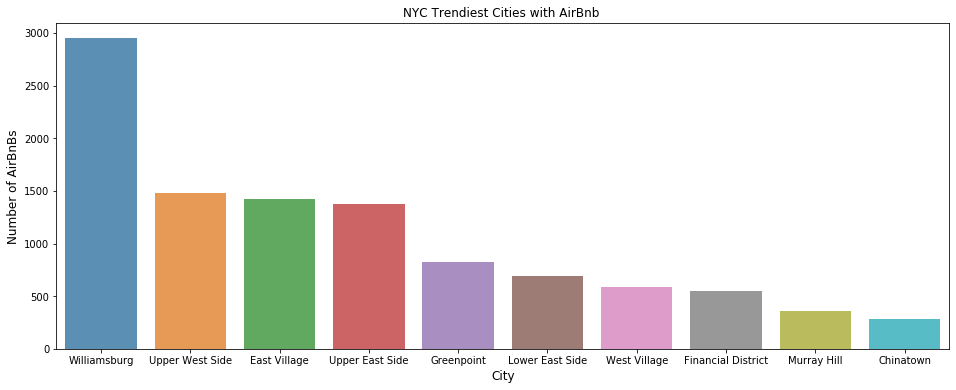

In [144]:
#Graph Of Top 10 Value Counts for trendiest cities
city_count  = X_train.trendy_cities.value_counts()
city_count = city_count[1:11,]
plt.figure(figsize=(16,6))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('NYC Trendiest Cities with AirBnb ')
plt.ylabel('Number of AirBnBs', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.show()

We will now use our trendiest cities column in the final model, all the other neighborhoods do not have much weight compared to these cities. We will still use all our numeric features and other categorical's with low cardianlity of less than 50. 

In [0]:
X_train_features = X_train
cardinality = X_train_features.select_dtypes(exclude='number').nunique()
numeric_features = X_train_features.select_dtypes(include='number').columns.tolist()

In [146]:
categorical_features

['neighborhood_group', 'room_type', 'trendy_cities']

In [0]:
features = numeric_features + categorical_features

In [148]:
#List of all the features we will use for this last model
features

['number_of_reviews',
 'latitude',
 'longitude',
 'minimum_nights',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'availability_by_minimum_nights',
 'neighborhood_group',
 'room_type',
 'trendy_cities']

In [0]:
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [151]:
X_train_encoded.head()

,number_of_reviews,latitude,longitude,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,availability_by_minimum_nights,neighborhood_group_Brooklyn,neighborhood_group_Manhattan,neighborhood_group_Queens,neighborhood_group_Bronx,neighborhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,trendy_cities_Greenpoint,trendy_cities_Williamsburg,trendy_cities_Other,trendy_cities_Murray Hill,trendy_cities_SoHo,trendy_cities_East Village,trendy_cities_Upper West Side,trendy_cities_Financial District,trendy_cities_Upper East Side,trendy_cities_West Village,trendy_cities_Arverne,trendy_cities_Flatiron District,trendy_cities_Lower East Side,trendy_cities_Chinatown,trendy_cities_NoHo,trendy_cities_Forest Hills,trendy_cities_Rockaway Beach,trendy_cities_Morningside Heights,trendy_cities_Theater District,trendy_cities_Tribeca,trendy_cities_Far Rockaway,trendy_cities_Jamaica Estates
45519,4,41,-74,3,3,1,181,60,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25847,4,41,-74,5,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30499,7,41,-74,6,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22741,4,41,-74,30,0,8,291,10,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43798,1,41,-74,4,1,1,17,4,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We will refit the data, and now neighborhood with high cardinality will not be involved in the model. Lets run the model and check out the results. 

In [152]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    XGBRegressor(n_estimators=150, random_state=42, n_jobs=-1, max_depth=5, min_child_weight=2 )
)

pipeline.fit(X_train_encoded, y_train)

[06:46:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=5, min_child_weight=2,
                              missing=None, n_estimators=150, n_jobs=-1,
                              nthread=None, objective='reg:linear',
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                     

In [153]:
#Final prediction on the Validation Set
y_pred = pipeline.predict(X_val_encoded)
r2 = r2_score(y_val, y_pred)

print('Mean Absolute Error', mean_absolute_error(y_val, y_pred))
print('R2 Score:', r2)

Mean Absolute Error 49.42058982727032
R2 Score: 0.43854752614835757


**Mean Absolute Error : 45.46**


**R2 Score : 0.49**

Test On Final Model

In [154]:
y_pred = pipeline.predict(X_test_encoded)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error', mean_absolute_error(y_test, y_pred))
print('R2 Score:', r2)

Mean Absolute Error 50.44836306596565
R2 Score: 0.40981893745824893


**Final Model on Test Set**

**Mean Absolute Error : 43**

**R2 Score  : 0.51**

We were able to get slightly better results to our final model than the previous model we tested. This model was able to smash the baseline mean that we set in our fast first model. Looks like some neighborhoods will effect the model more than others. This model was effective in the sense that it beat the mean baseline, significantly from the original score to the new model. We are able to make better predictions of price using this model according to the scoring metrics used. We can add more tuning and try some different regression models as well, to help try to improve the score more. 